<a href="https://colab.research.google.com/github/Matheuss1/artificial-intelligence-and-what-is-behind/blob/assignment-02/linear_regression_assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarefa \#2**: Machine Learning MC886/MO444
##**Regressão Linear**##

Universidade Estadual de Campinas (Unicamp)

Instituto de Computação (IC)

Prof. Marcelo Reis



In [1]:
# TODO: RA & Name 
print('241882: ' + 'Matheus Silva de Deus')
print('RA2: ' + 'Nome2')

241882: Matheus Silva de Deus
RA2: Nome2


## Objective: Predict life expectancy. 

Explore **linear regression** alternatives and come up with the best possible model to the problems, avoiding overfitting. In particular, predict the **Life expectancy** from their attributes.

## Dataset

The purpose of this dataset is to do health data analysis. The dataset related to life expectancy, health factors for 193 countries was collected from the same WHO data repository website and their corresponding economic data were collected from the United Nations website. Among all categories of health-related factors, only the critical factors that are most representative were chosen. All predictor variables were then divided into several broad categories: Immunization-related factors, Mortality factors, Economic factors, and Social factors.

Dataset Information: You should respect the following traininig/test split: 2056 training examples, and 882 test examples.

There are 22 attributes as follows: 

Data Dictionary

- Country	
- Year	
- Status		
- Adult Mortality	
- infant deaths	
- Alcohol	
- percentage expenditure	
- Hepatitis B	
- Measles	
- BMI	
- under-five deaths	
- Polio	
- Total 
- expenditure	
- Diphtheria	
- HIV/AIDS	
- GDP	
- Population	
- thinness  1-19 years	
- thinness 5-9 years	
- Income composition of resources	Schooling

- **Life expectancy**


The data is available at
- train: https://tinyurl.com/5374623f
- test: https://tinyurl.com/mtdkjf55


## Atividades

1. (5 pontos) Faça a Regressão Linear. Você deve implemetar a sua própria solução e comparar com ```sklearn.linear_model.SGDRegressor``` (modelo linear calculado com gradiente descendente estocástico da biblioteca [scikit-learn](http://scikit-learn.org)).
Não esqueça que o conjunto de testes NÃO deve ser utilizado para o **treinamento** do modelo.

**Dica: Verifique o conjunto de dados. Existem outliers? Estão faltando valores em alguns campos? Como utilizar variáveis categóricas?**


In [2]:
#import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline


In [3]:
# Tools to import the data to be used in this analysis

class GoogleDriveSheetDataImporter:
  @staticmethod
  def importData(sheet_id):
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

    return pd.read_csv(url)

TRAINING_DATA_SHEET_ID = '1ejB4RtHX6ma0XK51I6f_7AtDblKivlOtzSkxitdZYtA'
TEST_DATA_SHEET_ID = '1PrY9blDscKw5gWTyA3S34Gj3H5rRpuUU_b9rhVFsPQc'

In [4]:
# Tools to preprocess data

def convertStringDottedNumberToPythonInt(numberToConvert):
  if pd.isna(numberToConvert):
    return numberToConvert
    
  return int(numberToConvert.replace('.',''))

  
def applyToColumn(df, columnName, func):
  df[columnName] = df[columnName].apply(func)
  return df


def replaceMissingValues(df):
  numeric_columns = df.select_dtypes(include=np.number).columns

  return  df[numeric_columns].fillna(df.mean())


def meanNormalization(df):
  return (df - df.mean()) / df.std()


def getXValuesWithBiasIncludedInWeightsVector(X):
  rows_number = len(X)

  return np.c_[np.ones(rows_number), X]
  

In [5]:
# Get the train and test dataframes

train_df = GoogleDriveSheetDataImporter.importData(TRAINING_DATA_SHEET_ID)
test_df = GoogleDriveSheetDataImporter.importData(TEST_DATA_SHEET_ID)

In [6]:
# Transform numbers in string format to python number type

train_df = applyToColumn(train_df, 'percentage expenditure', convertStringDottedNumberToPythonInt)
train_df = applyToColumn(train_df, 'GDP', convertStringDottedNumberToPythonInt)

test_df = applyToColumn(test_df, 'percentage expenditure',convertStringDottedNumberToPythonInt)
test_df = applyToColumn(test_df, 'GDP', convertStringDottedNumberToPythonInt)

# Drop categorial variables (better results are given without them)
COLUMNS_TO_DROP = ['Country', 'Status', 'Diphtheria']


train_df = train_df.drop(columns=COLUMNS_TO_DROP)

test_df = test_df.drop(columns=COLUMNS_TO_DROP)

# Replace dataframe missing values (NaN)

train_df = replaceMissingValues(train_df)
test_df = replaceMissingValues(test_df)

# Normalize dataframe data

train_df = meanNormalization(train_df)
test_df = meanNormalization(test_df)

In [7]:
X_train = train_df.loc[:, train_df.columns != 'Life expectancy'].values
y_train = train_df['Life expectancy'].values

X_test = test_df.loc[:, test_df.columns != 'Life expectancy'].values
y_test = test_df['Life expectancy'].values

# Add a column of ones, to use bias inside weights vector
X_train = getXValuesWithBiasIncludedInWeightsVector(X_train)

X_test = getXValuesWithBiasIncludedInWeightsVector(X_test)


In [8]:
# TODO: Implemente aqui sua solução SEM utilizar bibliotecas prontas
#       como scikit-learn, Keras/TensorFlow, ou PyTorch.

rng = np.random.RandomState(0)

# Mean Squared Error


def mse_loss(y_pred, y_true):
    np_y_pred = np.array(y_pred)
    np_y_true = np.array(y_true)

    return np.mean((np_y_true - np_y_pred)**2)


def plot_history(model):
    plt.plot(model.history)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.show()


class SGDRegression():
    def __init__(self, learning_rate, max_iter):
        self.max_iter = max_iter  # maximo de iteracoes
        self.alpha = learning_rate  # taxa de aprendizado
        self.ws = None  # pesos

    def predict(self, X):
        return X @ self.ws

    # using sum of squares error to calculate the gradient
    def update_weights(self, y_pred, target, sample):
        n_weights = len(self.ws)
        stochastic_gradient = []

        for i in range(n_weights):
            wi_derivative = -2 * sample[i] * (y_pred - target)

            stochastic_gradient.append(wi_derivative)

        self.ws = self.ws - (self.alpha * np.array(stochastic_gradient))

    def fit(self, X, y):
        if self.ws is None:
            # init random weights
            ws = rng.randn(X.shape[1])
            self.ws = ws
        assert X.shape[0] == y.shape[0]

        history = []  # lista para guardar os valores de loss
        for i in range(self.max_iter):
            X, y = shuffle(X, y, random_state=0)
            avg_loss = []
            for sample, target in zip(X, y):
                y_pred = self.predict(sample)
                loss = mse_loss(y_pred, target)
                avg_loss.append(loss)
                self.update_weights(y_pred, target, sample)
            history.append((sum(avg_loss)/len(avg_loss)))
        self.history = history


In [9]:
lr = 10e-9 
max_iter = 1000
sgd_linear = SGDRegression(learning_rate=lr, max_iter=max_iter)
sgd_linear.fit(X_train, y_train)
print('W = ', sgd_linear.ws)

W =  [ 1.83810213  0.40134553  1.06624234  2.38607098  1.90537044 -1.02138427
  0.95831997 -0.08587809 -0.16518375  0.55697441  0.12039412  1.50376965
  0.84051388  0.12128992  0.5158351   0.44081784  1.61388956 -0.23744318
  0.27711678]


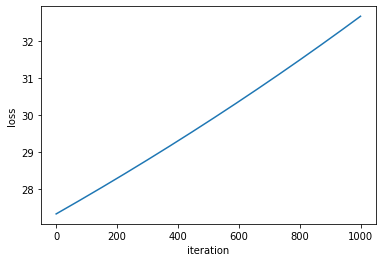

In [10]:
# Loss evolution over time
plot_history(sgd_linear)

In [11]:
# MSE loss in test set
y_pred = sgd_linear.predict(X_test)

mse_loss(y_pred, y_test)

32.42448282203471

In [12]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter=1000, tol=1e-3, shuffle=True)

reg.fit(X_train, y_train)

print('W = ', reg.coef_)

W =  [-0.00679213  0.02471579 -0.31348089  0.06292407  0.06396399  0.02560808
 -0.02005252 -0.04995627  0.11199605 -0.10293167  0.11581741  0.0224941
 -0.27518474 -0.00688041  0.00556858 -0.0389193   0.0366787   0.07450452
  0.31369275]


In [13]:
# MSE loss in test set using sklearn SGDRegressor
y_pred = reg.predict(X_test)

mse_loss(y_pred, y_test)

0.20510795480543473


>**Quais são as suas conclusões? (1-2 parágrafos)**




2. (2 points) Treine o modelo de regressão linear otimizado com Gradiente Descendente (GD) com 3 taxas de aprendizado diferentes. Compare os resultados dos modelos de GD com a solução com a equação normal (pseudo-inversa). 

In [ ]:
# TODO: Gradiente Descente (GD) com 3 taxas de aprendizado diferentes. 
lr1 = -1 #substitua por uma taxa de aprendizado válida
max_iter = -1 #substitua por um número máximo de iterações válido
sgd_linear_lr1 = SGDRegression(learning_rate=lr1, max_iter=max_iter)
sgd_linear_lr1.fit(X_train, y_train) #treinamento
print('Taxa de aprendizado = ', lr1, ' W = ', sgd_linear_lr1.ws)

lr2 = -1 #substitua por uma taxa de aprendizado válida
max_iter = -1 #substitua por um número máximo de iterações válido
sgd_linear_lr2 = SGDRegression(learning_rate=lr2, max_iter=max_iter)
sgd_linear_lr2.fit(X_train, y_train) #treinamento
print('Taxa de aprendizado = ', lr2, ' W = ', sgd_linear_lr2.ws)

lr3 = -1 #substitua por uma taxa de aprendizado válida
max_iter = -1 #substitua por um número máximo de iterações válido
sgd_linear_lr3 = SGDRegression(learning_rate=lr3, max_iter=max_iter)
sgd_linear_lr3.fit(X_train, y_train) #treinamento
print('Taxa de aprendizado = ', lr3, ' W = ', sgd_linear_lr3.ws)

In [ ]:
# Calcule e compare o MSE no conjunto de testes para cada modelo

In [ ]:
# TODO: Implemente aqui sua solução para regressão linear com equação normal

class NERegression():
    def __init__(self):
      self.ws = None #pesos
    
    def predict(self, X):
      # Use essa função para calcular y a partir de X e ws. 
      # Não esqueça de adicionar o bias.
      pass #remova essa linha

    def fit(self, X, y):
      #Use essa função para calcular a matriz de pesos com a equação normal
      self.ws = None #Substitua pelo calculo da equação normal

In [ ]:
#TODO: Calcule o modelo de regressão linear utilizando equação normal
ne = NERegression()
ne.fit(X_train, y_train)
print("W = ", ne.ws)

In [ ]:
# Calcule o MSE no conjunto de testes

   > **Quais são as suas conclusões? (1-2 parágrafos):**


3. (2 points) Às vezes, funções mais complexas geram melhores predições. Desenvolva e avalie um modelo de regressão polinomial.



In [ ]:
# TODO: Implemente aqui sua função para gerar um modelo de regressão polinomial.
#       Não utilize bibliotecas prontas como scikit-learn, Keras/TensorFlow, ou PyTorch.

class PolyFeatures():
    def __init__(self, degree):
      self.degree = degree #grau da nova matriz X

    def transform(self, X):
      #use essa função para gerar a nova matriz X
      X_poly = None #substitua pela geração do X polinomial
      return X_poly

In [ ]:
degree = -1 #escolha o grau da regressão polinomial
poly_feat = PolyFeatures(degree)
X_train_poly = poly_feat.transform(X_train)

In [ ]:
lr = -1 #substitua por uma taxa de aprendizado válida
max_iter = -1 #substitua por um número máximo de iterações válido
sgd_poly = SGDRegression(learning_rate=lr, max_iter=max_iter)
sgd_poly.fit(X_train_poly, y_train) #treinamento
print('W = ', sgd_poly.ws)

In [ ]:
#Evolução da loss ao longo do tempo
plot_history(sgd_poly)


 > **Quais as suas conclusões?(1-2 parágrafos):**

 


4. (1 point) Avalie os gráficos da função de custo vs. número de iterações no conjunto de treino. Quais conclusões você pode chegar a respeito dos modelos de GD ao analisar os gráficos?

In [ ]:
print('Função de custo vs. Numero de iterações GD linear')
plot_history(sgd_linear)

In [ ]:
print('Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =  ', lr1)
plot_history(sgd_linear_lr1)

In [ ]:
print('Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =  ', lr2)
plot_history(sgd_linear_lr2)

In [ ]:
print('Função de custo vs. Numero de iterações GD linear com taxa de aprendizado =  ', lr3)
plot_history(sgd_linear_lr3)

In [ ]:
print('Função de custo vs. Numero de iterações GD Polinomial')
plot_history(sgd_poly)

> **Escreva aqui suas conclusões (2-4 parágrafos)**


## Prazo: 19 de Abril, Terça-feira, 23:59

Política de penalidade para submissões atrasadas: Você não está sendo encorajada(o) a submeter o trabalho depois da data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:

- 20 de Abril 23:59 : nota * 0.75
- 21 de Abril 23:59 : nota * 0.5
- 22 de Abril 23:59 : nota * 0.25


## Submissão
- Submita seu notebook no Google Classroom. (Em português ou inglês).

- Apenas UMA pessoa da dupla precisa enviar o notebook.

- Não esqueça de colocar seus respectivos nomes & RAs.

- **Esta atividade NÃO é individual, deve ser realizada em dupla.**